In [1]:
import os

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance as yf
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_57878/1301272536.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [20]:
import yfinance as yf

start = "2014-09-17"
end = "2024-02-14"
symbol = {"GC=F"}
df = yf.download(symbol, start, end, auto_adjust=True)

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2024-02-07,2032.800049,2039.500000,2032.699951,2035.199951,71
2024-02-08,2028.000000,2036.699951,2020.300049,2032.199951,341
2024-02-09,2032.000000,2032.000000,2020.000000,2023.300049,62
2024-02-12,2025.500000,2025.500000,2011.599976,2018.199951,317
2024-02-13,2025.099976,2025.800049,1990.000000,1992.900024,198


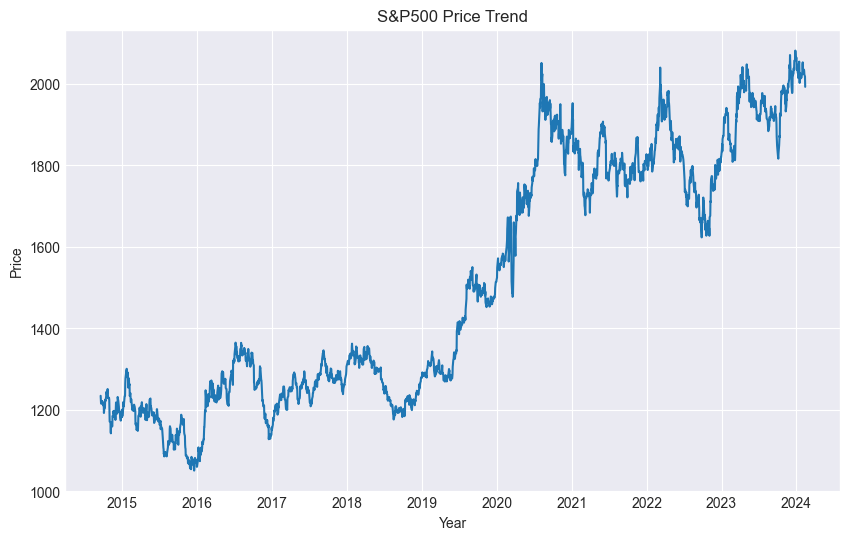

In [3]:
# Plot the time series data to understand its patterns and trends

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title("S&P500 Price Trend")
plt.plot(df['Close'])


In [4]:
from statsmodels.tsa.stattools import adfuller
# If data is not stationary according to the ADF test, it has to be converted into a stationary data for building up Machine Learning Model.
# Define a function to perform the Augmented Dickey-Fuller (ADF) test

def augmented_dickey_fuller_test(timeseries):
    # Perform the ADF test
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Print the results
    print('Results of Dickey-Fuller Test:')
    # Create a pandas Series to display the test statistics, p-value, number of lags used, and number of observations used
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add critical values to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    # Print the Series containing test results
    print(dfoutput)
    
    # Determine stationarity
    if dftest[1] > 0.05:
        print("Is Stationary: No (fail to reject)")
    else:
        print("Is Stationary: Yes (reject)")

# Call the function to perform the ADF test
print(augmented_dickey_fuller_test(df['Close']))

Results of Dickey-Fuller Test:
Test Statistic                   -0.639274
p-value                           0.861858
#Lags Used                        7.000000
Number of Observations Used    2359.000000
Critical Value (1%)              -3.433125
Critical Value (5%)              -2.862766
Critical Value (10%)             -2.567423
dtype: float64
Is Stationary: No (fail to reject)
None


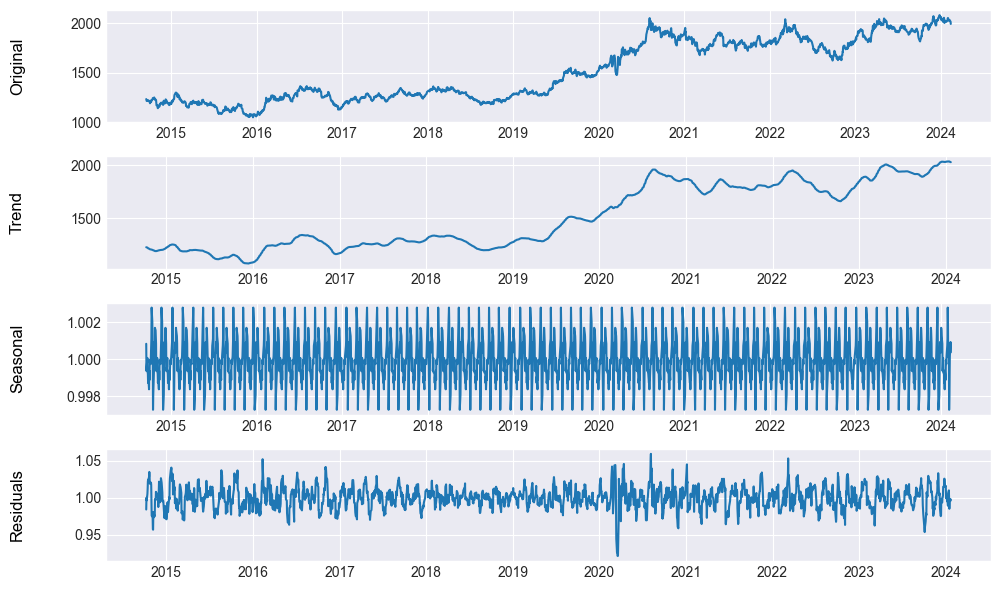

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(df["Close"], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(df["Close"], label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [6]:
# Check the trend's staionary after decomposition : NO

trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                   -0.430687
p-value                           0.904848
#Lags Used                       27.000000
Number of Observations Used    2309.000000
Critical Value (1%)              -3.433185
Critical Value (5%)              -2.862793
Critical Value (10%)             -2.567437
dtype: float64
Is Stationary: No (fail to reject)


In [7]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

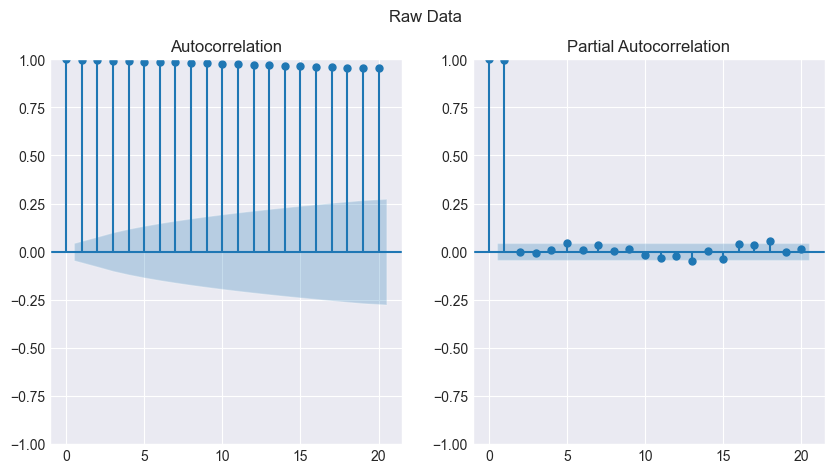

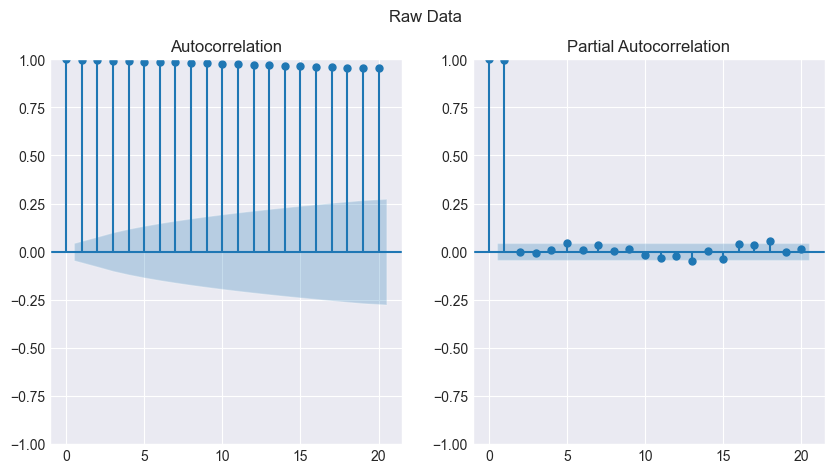

In [8]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [9]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print()
print(train_data['Close'].head())
print()
print(diff_train_data.head())


Date
2014-09-17    1234.400024
2014-09-18    1225.699951
2014-09-19    1215.300049
2014-09-22    1216.800049
2014-09-23    1221.000000
Name: Close, dtype: float64

Date
2014-09-18    -8.700073
2014-09-19   -10.399902
2014-09-22     1.500000
2014-09-23     4.199951
2014-09-24    -2.400024
Name: Close, dtype: float64


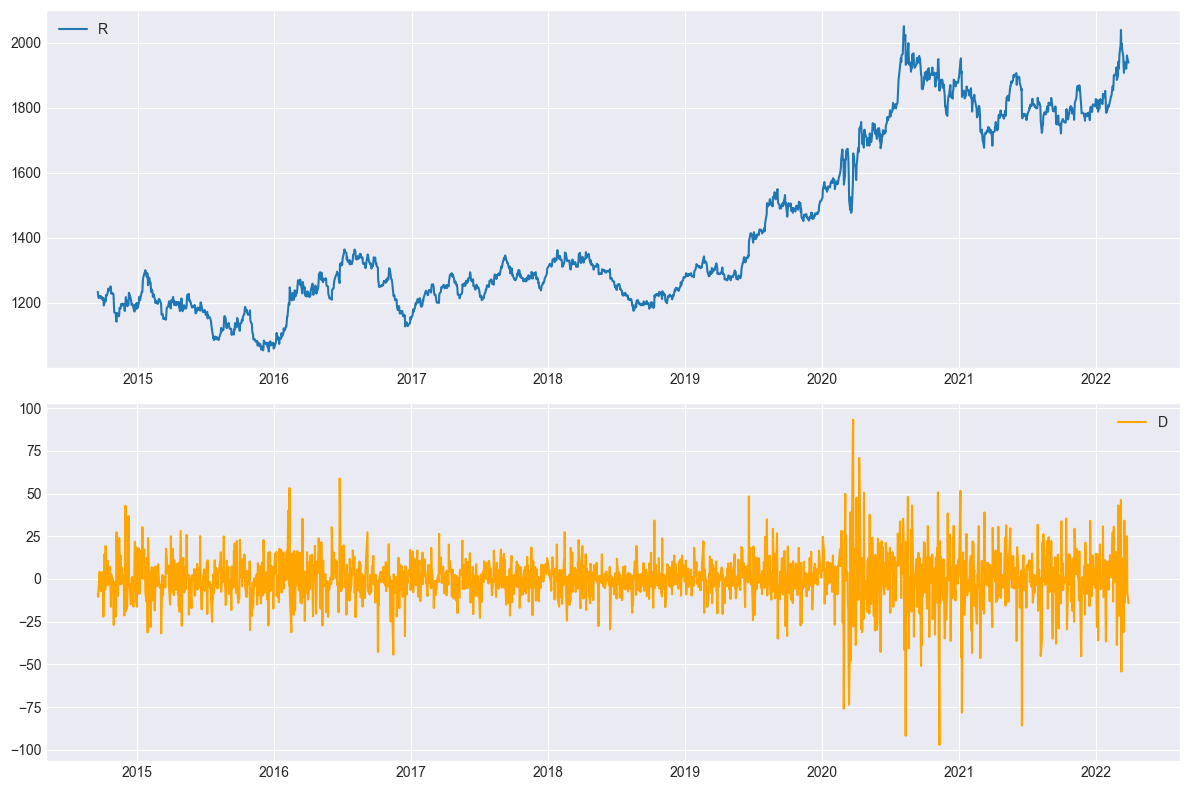

In [10]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

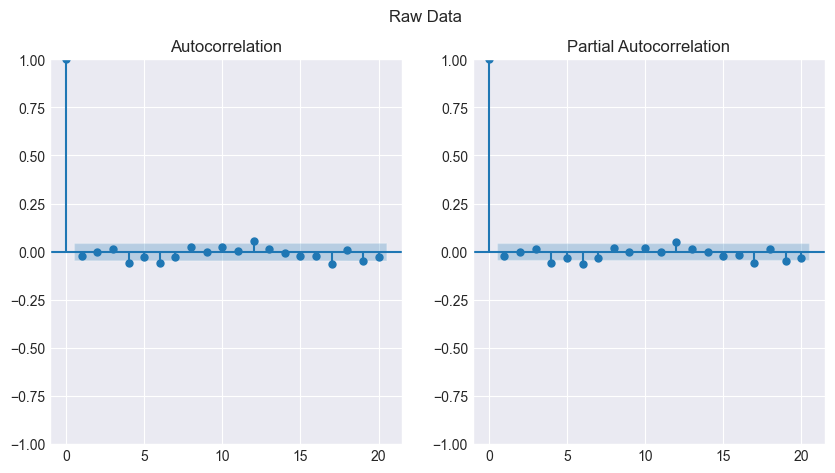

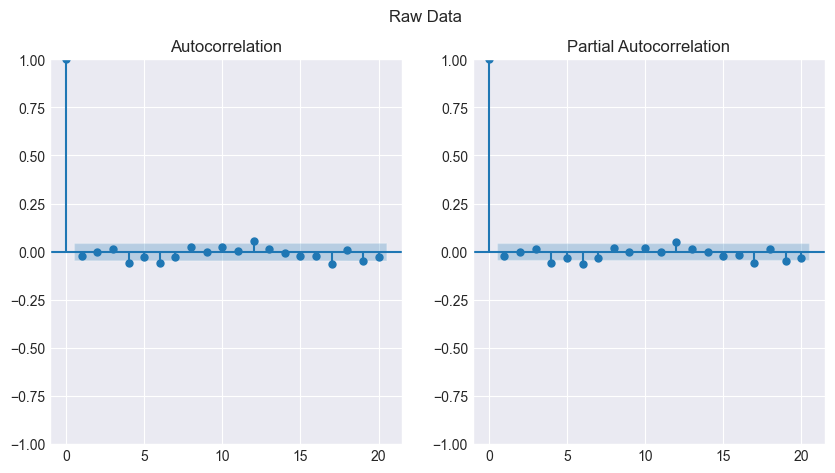

In [11]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

In [12]:
# parameter search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try : 
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))
            
        except Exception as e:
            print(e)
            continue

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40019D+00    |proj g|=  1.06284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.009D-07   4.400D+00
  F =   4.4001865525660167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 16661.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are

 This problem is unconstrained.



At iterate    5    f=  4.07043D+00    |proj g|=  7.79988D-03

At iterate   10    f=  4.06688D+00    |proj g|=  1.39365D-04

At iterate   15    f=  4.06668D+00    |proj g|=  2.87242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   5.797D-06   4.067D+00
  F =   4.0666604934014261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 15402.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.07715D+00    |proj g|=  2.21694D-02

At iterate   10    f=  4.06906D+00    |proj g|=  2.07060D-03

At iterate   15    f=  4.06749D+00    |proj g|=  1.94748D-02

At iterate   20    f=  4.06674D+00    |proj g|=  8.39888D-04

At iterate   25    f=  4.06667D+00    |proj g|=  5.58432D-04

At iterate   30    f=  4.06667D+00    |proj g|=  1.23291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     37      1     0     0   8.376D-06   4.067D+00
  F =   4.0666653169386002     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(1, 1, 1, 3) >> AIC : 15402.39
R

 This problem is unconstrained.



At iterate    5    f=  4.06853D+00    |proj g|=  7.82311D-03

At iterate   10    f=  4.06683D+00    |proj g|=  3.21593D-04

At iterate   15    f=  4.06672D+00    |proj g|=  4.33594D-04

At iterate   20    f=  4.06670D+00    |proj g|=  1.43124D-04

At iterate   25    f=  4.06642D+00    |proj g|=  1.43856D-02

At iterate   30    f=  4.06625D+00    |proj g|=  6.21424D-05

At iterate   35    f=  4.06624D+00    |proj g|=  4.48942D-05

At iterate   40    f=  4.06624D+00    |proj g|=  1.38348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     56      1     0     0   4.308D-06   4.066D+00
  F =   4.06624151083

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11763D+00    |proj g|=  1.47790D-01

At iterate    5    f=  4.07303D+00    |proj g|=  3.23003D-02

At iterate   10    f=  4.06555D+00    |proj g|=  3.13834D-03

At iterate   15    f=  4.06484D+00    |proj g|=  4.51352D-04

At iterate   20    f=  4.06479D+00    |proj g|=  1.40522D-04

At iterate   25    f=  4.06479D+00    |proj g|=  8.39704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.07102D+00    |proj g|=  6.31449D-03

At iterate   10    f=  4.06679D+00    |proj g|=  7.05592D-04

At iterate   15    f=  4.06668D+00    |proj g|=  9.35631D-04

At iterate   20    f=  4.06664D+00    |proj g|=  1.07067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   9.546D-06   4.067D+00
  F =   4.0666383941761737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : 15406.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0     

 This problem is unconstrained.
 This problem is unconstrained.


SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : 16663.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19520D+00    |proj g|=  5.40790D-02

At iterate    5    f=  4.06923D+00    |proj g|=  3.36971D-02

At iterate   10    f=  4.06679D+00    |proj g|=  9.02559D-04

At iterate   15    f=  4.06664D+00    |proj g|=  8.60623D-04

At iterate   20    f=  4.06655D+00    |proj g|=  6.08845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   4.537D-06   

 This problem is unconstrained.



At iterate    5    f=  4.07071D+00    |proj g|=  2.15634D-02

At iterate   10    f=  4.06981D+00    |proj g|=  8.86642D-03

At iterate   15    f=  4.06673D+00    |proj g|=  1.61033D-03

At iterate   20    f=  4.06647D+00    |proj g|=  2.29737D-03

At iterate   25    f=  4.06644D+00    |proj g|=  3.06381D-04

At iterate   30    f=  4.06643D+00    |proj g|=  8.26818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     41      1     0     0   5.872D-05   4.066D+00
  F =   4.0664332470524851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 15403.52
R

 This problem is unconstrained.


SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 16214.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18214D+00    |proj g|=  9.56387D-02


 This problem is unconstrained.



At iterate    5    f=  4.07850D+00    |proj g|=  1.12111D-01

At iterate   10    f=  4.06854D+00    |proj g|=  5.19194D-03

At iterate   15    f=  4.06663D+00    |proj g|=  2.01071D-03

At iterate   20    f=  4.06647D+00    |proj g|=  4.89591D-04

At iterate   25    f=  4.06645D+00    |proj g|=  4.81370D-04

At iterate   30    f=  4.06645D+00    |proj g|=  7.30378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     41      1     0     0   9.887D-05   4.066D+00
  F =   4.0664461872547406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 15403.57
R

 This problem is unconstrained.



At iterate    5    f=  4.06796D+00    |proj g|=  2.22800D-02

At iterate   10    f=  4.06645D+00    |proj g|=  3.60270D-05

At iterate   15    f=  4.06645D+00    |proj g|=  1.88580D-04

At iterate   20    f=  4.06644D+00    |proj g|=  3.65733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   8.451D-06   4.066D+00
  F =   4.0664433588177387     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(1, 1, 2, 3) >> AIC : 15405.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.21741D+00    |proj g|=  8.26662D-02

At iterate   10    f=  4.21287D+00    |proj g|=  3.29985D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   3.300D-06   4.213D+00
  F =   4.2128701739288132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 15957.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18371D+00    |proj g|=  9.17746D-02


 This problem is unconstrained.



At iterate    5    f=  4.10761D+00    |proj g|=  1.17543D-01

At iterate   10    f=  4.06629D+00    |proj g|=  1.29781D-03

At iterate   15    f=  4.06597D+00    |proj g|=  8.68918D-03

At iterate   20    f=  4.06459D+00    |proj g|=  8.18900D-04

At iterate   25    f=  4.06450D+00    |proj g|=  3.49120D-03

At iterate   30    f=  4.06449D+00    |proj g|=  1.14348D-04

At iterate   35    f=  4.06448D+00    |proj g|=  5.81374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     48      1     0     0   8.275D-06   4.064D+00
  F =   4.0644832373383686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.06878D+00    |proj g|=  2.02808D-02

At iterate   10    f=  4.06642D+00    |proj g|=  1.87172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   6.662D-06   4.066D+00
  F =   4.0664012709981447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : 15407.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39997D+00    |proj g|=  2.14387D-02

At iterate    5    f

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19542D+00    |proj g|=  5.39505D-02

At iterate    5    f=  4.11035D+00    |proj g|=  5.97010D-02

At iterate   10    f=  4.06674D+00    |proj g|=  2.13046D-04

At iterate   15    f=  4.06671D+00    |proj g|=  2.16918D-03

At iterate   20    f=  4.06656D+00    |proj g|=  6.50114D-04

At iterate   25    f=  4.06654D+00    |proj g|=  1.89698D-05

At iterate   30    f=  4.06653D+00    |proj g|=  2.29935D-04

At iterate   35    f=  4.06653D+00    |proj g|=  2.89409D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  4.07038D+00    |proj g|=  1.23649D-02

At iterate   10    f=  4.07000D+00    |proj g|=  6.91030D-03

At iterate   15    f=  4.06682D+00    |proj g|=  6.10041D-03

At iterate   20    f=  4.06647D+00    |proj g|=  8.92386D-04

At iterate   25    f=  4.06644D+00    |proj g|=  2.99508D-04

At iterate   30    f=  4.06643D+00    |proj g|=  8.15245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   9.870D-06   4.066D+00
  F =   4.0664310994728412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(0, 1, 2, 3) >> AIC : 15405.51
R

 This problem is unconstrained.


SARIMA : (0, 1, 2),(1, 1, 0, 3) >> AIC : 16215.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18240D+00    |proj g|=  9.54750D-02


 This problem is unconstrained.



At iterate    5    f=  4.08130D+00    |proj g|=  1.45028D-01

At iterate   10    f=  4.06866D+00    |proj g|=  1.35763D-03

At iterate   15    f=  4.06843D+00    |proj g|=  8.91900D-03

At iterate   20    f=  4.06670D+00    |proj g|=  2.07573D-03

At iterate   25    f=  4.06648D+00    |proj g|=  6.36209D-04

At iterate   30    f=  4.06645D+00    |proj g|=  7.36968D-04

At iterate   35    f=  4.06644D+00    |proj g|=  2.89682D-04

At iterate   40    f=  4.06644D+00    |proj g|=  1.05947D-04

At iterate   45    f=  4.06644D+00    |proj g|=  4.62617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     53   

 This problem is unconstrained.



At iterate    5    f=  4.07425D+00    |proj g|=  1.02721D-01

At iterate   10    f=  4.06647D+00    |proj g|=  1.31586D-04

At iterate   15    f=  4.06647D+00    |proj g|=  3.78114D-05

At iterate   20    f=  4.06647D+00    |proj g|=  1.37642D-03

At iterate   25    f=  4.06645D+00    |proj g|=  1.99159D-03

At iterate   30    f=  4.06644D+00    |proj g|=  4.53084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     33      1     0     0   4.531D-05   4.066D+00
  F =   4.0664406420635526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(1, 1, 2, 3) >> AIC : 15407.54
R

 This problem is unconstrained.



At iterate    5    f=  4.21355D+00    |proj g|=  2.28875D-02

At iterate   10    f=  4.21283D+00    |proj g|=  8.50591D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   8.506D-06   4.213D+00
  F =   4.2128251435984438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(2, 1, 0, 3) >> AIC : 15959.76
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18397D+00    |proj g|=  9.16290D-02

At iterate    5    f=  4.10481D+00    |proj g|=  1.16979D-01

At iterate   10    f=  4.06632D+00    |proj g|=  7.62252D-04

At iterate   15    f=  4.06609D+00    |proj g|=  9.73069D-03

At iterate   20    f=  4.06457D+00    |proj g|=  1.72603D-03

At iterate   25    f=  4.06449D+00    |proj g|=  6.91738D-04

At iterate   30    f=  4.06448D+00    |proj g|=  2.16630D-04

At iterate   35    f=  4.06447D+00    |proj g|=  4.21409D-05

At iterate   40    f=  4.06447D+00    |proj g|=  2.65775D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final project

 This problem is unconstrained.



At iterate    5    f=  4.07275D+00    |proj g|=  6.39379D-02

At iterate   10    f=  4.06687D+00    |proj g|=  8.03842D-03

At iterate   15    f=  4.06640D+00    |proj g|=  2.82554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   4.646D-06   4.066D+00
  F =   4.0664004523784687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(2, 1, 2, 3) >> AIC : 15409.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.06676D+00    |proj g|=  1.37697D-04

At iterate   15    f=  4.06674D+00    |proj g|=  4.34739D-03

At iterate   20    f=  4.06657D+00    |proj g|=  1.42754D-04

At iterate   25    f=  4.06654D+00    |proj g|=  1.96116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     31      1     0     0   7.310D-06   4.067D+00
  F =   4.0665380230697137     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(0, 1, 1, 3) >> AIC : 15401.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.07109D+00    |proj g|=  9.06358D-03

At iterate   10    f=  4.06783D+00    |proj g|=  3.67005D-03

At iterate   15    f=  4.06653D+00    |proj g|=  1.51760D-03

At iterate   20    f=  4.06645D+00    |proj g|=  2.71451D-04

At iterate   25    f=  4.06644D+00    |proj g|=  2.15983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   3.869D-05   4.066D+00
  F =   4.0664348846676690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(0, 1, 2, 3) >> AIC : 15403.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18178D+00    |proj g|=  9.59257D-02

At iterate    5    f=  4.07949D+00    |proj g|=  1.34892D-01

At iterate   10    f=  4.06821D+00    |proj g|=  2.04582D-03

At iterate   15    f=  4.06674D+00    |proj g|=  2.61528D-03

At iterate   20    f=  4.06648D+00    |proj g|=  6.11496D-04

At iterate   25    f=  4.06645D+00    |proj g|=  1.61489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.07235D+00    |proj g|=  7.02897D-02

At iterate   10    f=  4.06648D+00    |proj g|=  3.29981D-04

At iterate   15    f=  4.06648D+00    |proj g|=  2.17678D-04

At iterate   20    f=  4.06644D+00    |proj g|=  2.98171D-04

At iterate   25    f=  4.06644D+00    |proj g|=  6.36291D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   6.363D-06   4.066D+00
  F =   4.0664430314499791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(1, 1, 2, 3) >> AIC : 15405.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.21342D+00    |proj g|=  2.80266D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   5.800D-06   4.213D+00
  F =   4.2128655919894502     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(2, 1, 0, 3) >> AIC : 15957.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18335D+00    |proj g|=  9.20703D-02


 This problem is unconstrained.



At iterate    5    f=  4.10427D+00    |proj g|=  1.17273D-01

At iterate   10    f=  4.06629D+00    |proj g|=  7.42148D-04

At iterate   15    f=  4.06549D+00    |proj g|=  1.79937D-02

At iterate   20    f=  4.06454D+00    |proj g|=  2.25655D-03

At iterate   25    f=  4.06449D+00    |proj g|=  2.87414D-04

At iterate   30    f=  4.06449D+00    |proj g|=  1.59637D-04

At iterate   35    f=  4.06449D+00    |proj g|=  8.21023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     46      1     0     0   1.412D-05   4.064D+00
  F =   4.0644858304059479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.07497D+00    |proj g|=  4.57085D-02

At iterate   10    f=  4.06645D+00    |proj g|=  5.99480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   5.426D-06   4.066D+00
  F =   4.0664030560034634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(2, 1, 2, 3) >> AIC : 15407.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41199D+00    |proj g|=  1.30075D-02

At iterate    5    f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.09883D+00    |proj g|=  3.08716D-02

At iterate   10    f=  4.06670D+00    |proj g|=  1.48361D-04

At iterate   15    f=  4.06654D+00    |proj g|=  1.68647D-03

At iterate   20    f=  4.06562D+00    |proj g|=  3.00532D-03

At iterate   25    f=  4.06544D+00    |proj g|=  4.28579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   1.724D-06   4.065D+00
  F =   4.0654352567055447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(0, 1, 1, 3) >> AIC : 15399.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.09687D+00    |proj g|=  1.20082D-01

At iterate   10    f=  4.06933D+00    |proj g|=  8.18957D-03

At iterate   15    f=  4.06668D+00    |proj g|=  2.41133D-04

At iterate   20    f=  4.06645D+00    |proj g|=  1.27230D-03

At iterate   25    f=  4.06617D+00    |proj g|=  1.54180D-02

At iterate   30    f=  4.06486D+00    |proj g|=  4.56520D-03

At iterate   35    f=  4.06481D+00    |proj g|=  1.06555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     48      1     0     0   4.427D-05   4.065D+00
  F =   4.0648105744769323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  4.28105D+00    |proj g|=  5.27254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   3.386D-06   4.281D+00
  F =   4.2810502572211488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(1, 1, 0, 3) >> AIC : 16216.06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14224D+00    |proj g|=  1.18834D-01


 This problem is unconstrained.



At iterate    5    f=  4.08765D+00    |proj g|=  9.18947D-02

At iterate   10    f=  4.06872D+00    |proj g|=  3.01982D-03

At iterate   15    f=  4.06712D+00    |proj g|=  9.48742D-03

At iterate   20    f=  4.06652D+00    |proj g|=  3.03687D-03

At iterate   25    f=  4.06629D+00    |proj g|=  1.14936D-02

At iterate   30    f=  4.06505D+00    |proj g|=  1.07246D-02

At iterate   35    f=  4.06488D+00    |proj g|=  2.99426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     44      1     0     0   3.103D-06   4.065D+00
  F =   4.0648777555798947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.07770D+00    |proj g|=  5.35892D-02

At iterate   10    f=  4.06651D+00    |proj g|=  1.25953D-03

At iterate   15    f=  4.06645D+00    |proj g|=  2.24866D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     41      1     0     0   2.968D-05   4.066D+00
  F =   4.0664447805498458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(1, 1, 2, 3) >> AIC : 15407.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.21429D+00    |proj g|=  4.52003D-02

At iterate   10    f=  4.21286D+00    |proj g|=  1.47810D-04

At iterate   15    f=  4.21280D+00    |proj g|=  1.46083D-02

At iterate   20    f=  4.21064D+00    |proj g|=  9.86549D-03

At iterate   25    f=  4.20944D+00    |proj g|=  2.02760D-03

At iterate   30    f=  4.20940D+00    |proj g|=  9.49602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   1.580D-07   4.209D+00
  F =   4.2094009820320926     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(2, 1, 0, 3) >> AIC : 15946.79
R

 This problem is unconstrained.



At iterate    5    f=  4.09366D+00    |proj g|=  7.29509D-02

At iterate   10    f=  4.06646D+00    |proj g|=  8.19612D-04

At iterate   15    f=  4.06597D+00    |proj g|=  1.52711D-02

At iterate   20    f=  4.06456D+00    |proj g|=  2.42964D-03

At iterate   25    f=  4.06407D+00    |proj g|=  7.97624D-03

At iterate   30    f=  4.06371D+00    |proj g|=  2.67828D-03

At iterate   35    f=  4.06369D+00    |proj g|=  3.44983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     42      1     0     0   6.597D-06   4.064D+00
  F =   4.0636897388571693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.08579D+00    |proj g|=  2.10723D-02

At iterate   10    f=  4.06641D+00    |proj g|=  1.13575D-04

At iterate   15    f=  4.06641D+00    |proj g|=  1.86027D-04

At iterate   20    f=  4.06616D+00    |proj g|=  1.57887D-02

At iterate   25    f=  4.06507D+00    |proj g|=  3.78122D-03

At iterate   30    f=  4.06488D+00    |proj g|=  7.90223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     43      1     0     0   1.008D-05   4.065D+00
  F =   4.0648757851804849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(2, 1, 2, 3) >> AIC : 15403.62
R

 This problem is unconstrained.



At iterate   10    f=  4.28299D+00    |proj g|=  1.02604D-02

At iterate   15    f=  4.27630D+00    |proj g|=  4.78004D-01

At iterate   20    f=  4.27167D+00    |proj g|=  1.06355D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   3.829D-05   4.272D+00
  F =   4.2716731646382238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(0, 1, 0, 3) >> AIC : 16180.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.10687D+00    |proj g|=  7.91025D-02

At iterate   10    f=  4.06667D+00    |proj g|=  1.01344D-04

At iterate   15    f=  4.06654D+00    |proj g|=  1.01755D-02

At iterate   20    f=  4.06630D+00    |proj g|=  2.64484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   3.923D-05   4.066D+00
  F =   4.0662919339137282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(0, 1, 1, 3) >> AIC : 15404.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.11990D+00    |proj g|=  1.53286D-01

At iterate   10    f=  4.07026D+00    |proj g|=  3.45295D-03

At iterate   15    f=  4.06994D+00    |proj g|=  7.09161D-03

At iterate   20    f=  4.06692D+00    |proj g|=  5.27338D-03

At iterate   25    f=  4.06644D+00    |proj g|=  8.95231D-03

At iterate   30    f=  4.06626D+00    |proj g|=  1.08245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     38      1     0     0   3.425D-05   4.066D+00
  F =   4.0662580192934410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(0, 1, 2, 3) >> AIC : 15406.85
R

 This problem is unconstrained.



At iterate    5    f=  4.28063D+00    |proj g|=  3.78029D-02

At iterate   10    f=  4.27778D+00    |proj g|=  9.45280D-03

At iterate   15    f=  4.27708D+00    |proj g|=  1.78973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.233D-06   4.277D+00
  F =   4.2770740189496470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(1, 1, 0, 3) >> AIC : 16203.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

 This problem is unconstrained.



At iterate    5    f=  4.09026D+00    |proj g|=  1.53129D-01

At iterate   10    f=  4.06867D+00    |proj g|=  9.48667D-04

At iterate   15    f=  4.06851D+00    |proj g|=  9.00612D-03

At iterate   20    f=  4.06662D+00    |proj g|=  5.18401D-03

At iterate   25    f=  4.06647D+00    |proj g|=  5.70524D-04

At iterate   30    f=  4.06633D+00    |proj g|=  3.77872D-03

At iterate   35    f=  4.06625D+00    |proj g|=  3.23699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   7.685D-06   4.066D+00
  F =   4.0662544544386998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.09144D+00    |proj g|=  9.67360D-02

At iterate   10    f=  4.06666D+00    |proj g|=  6.52561D-03

At iterate   15    f=  4.06646D+00    |proj g|=  6.41402D-05

At iterate   20    f=  4.06645D+00    |proj g|=  7.77289D-04

At iterate   25    f=  4.06639D+00    |proj g|=  1.98838D-04

At iterate   30    f=  4.06634D+00    |proj g|=  3.05715D-03

At iterate   35    f=  4.06624D+00    |proj g|=  5.60581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     49      1     0     0   3.658D-06   4.066D+00
  F =   4.0662413638946662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.21273D+00    |proj g|=  7.28812D-03

At iterate   10    f=  4.21242D+00    |proj g|=  9.46093D-03

At iterate   15    f=  4.21167D+00    |proj g|=  1.05921D-03

At iterate   20    f=  4.21167D+00    |proj g|=  9.54294D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     28      1     0     0   9.543D-06   4.212D+00
  F =   4.2116667781036581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(2, 1, 0, 3) >> AIC : 15957.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.11107D+00    |proj g|=  1.26251D-01

At iterate   10    f=  4.06636D+00    |proj g|=  9.57063D-04

At iterate   15    f=  4.06620D+00    |proj g|=  1.10912D-02

At iterate   20    f=  4.06463D+00    |proj g|=  3.23877D-03

At iterate   25    f=  4.06450D+00    |proj g|=  9.45166D-04

At iterate   30    f=  4.06448D+00    |proj g|=  3.03194D-04

At iterate   35    f=  4.06439D+00    |proj g|=  1.32487D-02

At iterate   40    f=  4.06371D+00    |proj g|=  1.91581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     54      1     0     0   9.079D-06   4.064D+00
  F =   4.06368093417

 This problem is unconstrained.



At iterate    5    f=  4.08859D+00    |proj g|=  7.25684D-02

At iterate   10    f=  4.06641D+00    |proj g|=  4.52687D-04

At iterate   15    f=  4.06640D+00    |proj g|=  2.71094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     20      1     0     0   1.635D-05   4.066D+00
  F =   4.0663991995213165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(2, 1, 2, 3) >> AIC : 15411.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.07314D+00    |proj g|=  8.56828D-02

At iterate   10    f=  4.06674D+00    |proj g|=  1.24175D-04

At iterate   15    f=  4.06673D+00    |proj g|=  3.48242D-03

At iterate   20    f=  4.06656D+00    |proj g|=  8.16484D-04

At iterate   25    f=  4.06654D+00    |proj g|=  5.77117D-04

At iterate   30    f=  4.06653D+00    |proj g|=  6.07907D-05

At iterate   35    f=  4.06653D+00    |proj g|=  4.90643D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     37      1     0     0   4.906D-05   4.067D+00
  F =   4.0665325649880080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.07082D+00    |proj g|=  2.58998D-02

At iterate   10    f=  4.07020D+00    |proj g|=  7.40600D-03

At iterate   15    f=  4.06751D+00    |proj g|=  1.01834D-02

At iterate   20    f=  4.06653D+00    |proj g|=  2.28801D-03

At iterate   25    f=  4.06644D+00    |proj g|=  7.21168D-04

At iterate   30    f=  4.06643D+00    |proj g|=  5.14602D-04

At iterate   35    f=  4.06643D+00    |proj g|=  6.16105D-05

At iterate   40    f=  4.06643D+00    |proj g|=  1.39725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     52      1     0     0   1.732D-05   4.066D+00
  F =   4.06643134131

 This problem is unconstrained.



At iterate    5    f=  4.28094D+00    |proj g|=  4.70740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   6.172D-06   4.281D+00
  F =   4.2809131080426628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(1, 1, 0, 3) >> AIC : 16215.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18175D+00    |proj g|=  9.55330D-02


 This problem is unconstrained.



At iterate    5    f=  4.08014D+00    |proj g|=  1.28934D-01

At iterate   10    f=  4.06849D+00    |proj g|=  1.79524D-03

At iterate   15    f=  4.06680D+00    |proj g|=  2.08501D-03

At iterate   20    f=  4.06650D+00    |proj g|=  2.79029D-03

At iterate   25    f=  4.06645D+00    |proj g|=  1.09989D-04

At iterate   30    f=  4.06644D+00    |proj g|=  6.73333D-05

At iterate   35    f=  4.06644D+00    |proj g|=  1.14874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     48      1     0     0   3.176D-05   4.066D+00
  F =   4.0664440874032346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.07059D+00    |proj g|=  5.83484D-02

At iterate   10    f=  4.06646D+00    |proj g|=  1.39382D-03

At iterate   15    f=  4.06645D+00    |proj g|=  3.48211D-04

At iterate   20    f=  4.06644D+00    |proj g|=  1.44450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     30      1     0     0   1.276D-05   4.066D+00
  F =   4.0664414458819884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(1, 1, 2, 3) >> AIC : 15407.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate   10    f=  4.21278D+00    |proj g|=  2.80378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   4.264D-07   4.213D+00
  F =   4.2127837426048051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(2, 1, 0, 3) >> AIC : 15959.6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18332D+00    |proj g|=  9.16692D-02


 This problem is unconstrained.



At iterate    5    f=  4.10613D+00    |proj g|=  1.15573D-01

At iterate   10    f=  4.06629D+00    |proj g|=  8.21773D-04

At iterate   15    f=  4.06623D+00    |proj g|=  6.55461D-03

At iterate   20    f=  4.06470D+00    |proj g|=  7.73625D-03

At iterate   25    f=  4.06451D+00    |proj g|=  1.53531D-03

At iterate   30    f=  4.06448D+00    |proj g|=  9.61634D-05

At iterate   35    f=  4.06448D+00    |proj g|=  2.70092D-04

At iterate   40    f=  4.06448D+00    |proj g|=  1.20342D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     46      1     0     0   1.203D-05   4.064D+00
  F =   4.06447508963

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17233D+00    |proj g|=  3.02784D-02

At iterate    5    f=  4.07125D+00    |proj g|=  5.96597D-02

At iterate   10    f=  4.06668D+00    |proj g|=  1.10742D-02

At iterate   15    f=  4.06640D+00    |proj g|=  2.26169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   4.732D-06   4.066D+00
  F =   4.0664005952881759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA :

 This problem is unconstrained.



At iterate   15    f=  4.37605D+00    |proj g|=  1.03129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   4.708D-05   4.376D+00
  F =   4.3760464315992706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 0, 3) >> AIC : 16575.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15460D+00    |proj g|=  6.90352D-02


 This problem is unconstrained.



At iterate    5    f=  4.09536D+00    |proj g|=  1.95624D-02

At iterate   10    f=  4.06672D+00    |proj g|=  2.30011D-04

At iterate   15    f=  4.06668D+00    |proj g|=  2.90743D-03

At iterate   20    f=  4.06635D+00    |proj g|=  7.31989D-03

At iterate   25    f=  4.06623D+00    |proj g|=  1.60890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   1.440D-05   4.066D+00
  F =   4.0662256723375130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 1, 3) >> AIC : 15404.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.09570D+00    |proj g|=  1.08713D-01

At iterate   10    f=  4.07029D+00    |proj g|=  2.01589D-03

At iterate   15    f=  4.06890D+00    |proj g|=  1.46590D-02

At iterate   20    f=  4.06668D+00    |proj g|=  6.50937D-03

At iterate   25    f=  4.06646D+00    |proj g|=  2.94837D-04

At iterate   30    f=  4.06643D+00    |proj g|=  2.35294D-04

At iterate   35    f=  4.06630D+00    |proj g|=  5.27523D-03

At iterate   40    f=  4.06622D+00    |proj g|=  2.45661D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     52      1     0     0   2.457D-05   4.066D+00
  F =   4.06622397118

 This problem is unconstrained.



At iterate    5    f=  4.28087D+00    |proj g|=  4.34003D-03

At iterate   10    f=  4.27923D+00    |proj g|=  1.50288D-02

At iterate   15    f=  4.27908D+00    |proj g|=  1.51160D-04

At iterate   20    f=  4.27908D+00    |proj g|=  1.50681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.134D-06   4.279D+00
  F =   4.2790781169670069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 1),(1, 1, 0, 3) >> AIC : 16210.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.09291D+00    |proj g|=  1.77685D-01

At iterate   10    f=  4.06875D+00    |proj g|=  1.16206D-03

At iterate   15    f=  4.06787D+00    |proj g|=  1.95534D-02

At iterate   20    f=  4.06657D+00    |proj g|=  3.41764D-03

At iterate   25    f=  4.06646D+00    |proj g|=  7.82662D-04

At iterate   30    f=  4.06644D+00    |proj g|=  1.79316D-04

At iterate   35    f=  4.06627D+00    |proj g|=  4.21732D-03

At iterate   40    f=  4.06622D+00    |proj g|=  1.84653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     53      1     0     0   9.339D-06   4.066D+00
  F =   4.06622397515

 This problem is unconstrained.



At iterate    5    f=  4.07936D+00    |proj g|=  4.23294D-02

At iterate   10    f=  4.06645D+00    |proj g|=  1.78260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     17      1     0     0   7.825D-06   4.066D+00
  F =   4.0664446320627521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 1),(1, 1, 2, 3) >> AIC : 15409.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21756D+00    |proj g|=  1.80862D-02

At iterate    5    

 This problem is unconstrained.



At iterate   10    f=  4.21263D+00    |proj g|=  1.92678D-03

At iterate   15    f=  4.21247D+00    |proj g|=  1.28118D-02

At iterate   20    f=  4.21140D+00    |proj g|=  1.81684D-02

At iterate   25    f=  4.21052D+00    |proj g|=  8.15653D-03

At iterate   30    f=  4.20937D+00    |proj g|=  2.33798D-03

At iterate   35    f=  4.20929D+00    |proj g|=  2.90548D-04

At iterate   40    f=  4.20929D+00    |proj g|=  1.15394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     47      1     0     0   1.154D-05   4.209D+00
  F =   4.2092851887460911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.09374D+00    |proj g|=  5.32186D-02

At iterate   10    f=  4.06649D+00    |proj g|=  8.94792D-04

At iterate   15    f=  4.06567D+00    |proj g|=  2.79127D-02

At iterate   20    f=  4.06455D+00    |proj g|=  2.25949D-03

At iterate   25    f=  4.06449D+00    |proj g|=  4.39597D-04

At iterate   30    f=  4.06448D+00    |proj g|=  1.35849D-04

At iterate   35    f=  4.06433D+00    |proj g|=  1.58030D-02

At iterate   40    f=  4.06374D+00    |proj g|=  6.37179D-03

At iterate   45    f=  4.06368D+00    |proj g|=  8.34225D-04

At iterate   50    f=  4.06368D+00    |proj g|=  1.22231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.08498D+00    |proj g|=  3.37448D-02

At iterate   10    f=  4.06671D+00    |proj g|=  4.53456D-03

At iterate   15    f=  4.06640D+00    |proj g|=  1.30021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     20      1     0     0   1.462D-05   4.066D+00
  F =   4.0664029393829866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(2, 1, 2, 3) >> AIC : 15411.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

 This problem is unconstrained.



At iterate   10    f=  4.30552D+00    |proj g|=  1.27048D-02

At iterate   15    f=  4.30512D+00    |proj g|=  5.55462D-03

At iterate   20    f=  4.30389D+00    |proj g|=  4.48308D-03

At iterate   25    f=  4.30380D+00    |proj g|=  3.02586D-04

At iterate   30    f=  4.30377D+00    |proj g|=  1.07516D-04

At iterate   35    f=  4.30377D+00    |proj g|=  6.53949D-05

At iterate   40    f=  4.30377D+00    |proj g|=  1.96537D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     46      1     0     0   6.699D-06   4.304D+00
  F =   4.3037712185951600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.12196D+00    |proj g|=  3.50573D-02

At iterate   10    f=  4.06572D+00    |proj g|=  4.23066D-03

At iterate   15    f=  4.06564D+00    |proj g|=  1.56063D-03

At iterate   20    f=  4.06553D+00    |proj g|=  3.52899D-04

At iterate   25    f=  4.06551D+00    |proj g|=  6.02221D-04

At iterate   30    f=  4.06543D+00    |proj g|=  1.67478D-04

At iterate   35    f=  4.06542D+00    |proj g|=  1.06771D-04

At iterate   40    f=  4.06537D+00    |proj g|=  6.43361D-04

At iterate   45    f=  4.06536D+00    |proj g|=  8.28235D-05

At iterate   50    f=  4.06536D+00    |proj g|=  1.77764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.12100D+00    |proj g|=  1.20726D-01

At iterate   10    f=  4.06970D+00    |proj g|=  1.88827D-02

At iterate   15    f=  4.06798D+00    |proj g|=  6.66357D-03

At iterate   20    f=  4.06605D+00    |proj g|=  3.66396D-03

At iterate   25    f=  4.06568D+00    |proj g|=  1.05298D-03

At iterate   30    f=  4.06496D+00    |proj g|=  2.92052D-03

At iterate   35    f=  4.06451D+00    |proj g|=  8.04188D-04

At iterate   40    f=  4.06439D+00    |proj g|=  4.39190D-04

At iterate   45    f=  4.06438D+00    |proj g|=  5.71005D-04

At iterate   50    f=  4.06436D+00    |proj g|=  6.07528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.28328D+00    |proj g|=  4.50382D-02

At iterate   10    f=  4.27594D+00    |proj g|=  7.29393D-02

At iterate   15    f=  4.23220D+00    |proj g|=  5.05455D-02

At iterate   20    f=  4.20417D+00    |proj g|=  5.37705D-02

At iterate   25    f=  4.17373D+00    |proj g|=  1.48840D-02

At iterate   30    f=  4.16800D+00    |proj g|=  5.08747D-02

At iterate   35    f=  4.16486D+00    |proj g|=  6.64673D-02

At iterate   40    f=  4.16399D+00    |proj g|=  1.67599D-02

At iterate   45    f=  4.16389D+00    |proj g|=  3.13808D-03

At iterate   50    f=  4.16387D+00    |proj g|=  1.37400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.11823D+00    |proj g|=  1.01981D-01

At iterate   10    f=  4.06835D+00    |proj g|=  8.63391D-03

At iterate   15    f=  4.06809D+00    |proj g|=  8.40917D-03

At iterate   20    f=  4.06617D+00    |proj g|=  5.08068D-03

At iterate   25    f=  4.06596D+00    |proj g|=  4.75349D-04

At iterate   30    f=  4.06548D+00    |proj g|=  1.59236D-03

At iterate   35    f=  4.06489D+00    |proj g|=  5.06390D-03

At iterate   40    f=  4.06448D+00    |proj g|=  4.72855D-04

At iterate   45    f=  4.06443D+00    |proj g|=  8.45125D-05

At iterate   50    f=  4.06443D+00    |proj g|=  5.37509D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.08114D+00    |proj g|=  9.12904D-02

At iterate   10    f=  4.06633D+00    |proj g|=  1.25102D-03

At iterate   15    f=  4.06611D+00    |proj g|=  1.93562D-03

At iterate   20    f=  4.06557D+00    |proj g|=  1.09798D-02

At iterate   25    f=  4.06532D+00    |proj g|=  5.63309D-04

At iterate   30    f=  4.06532D+00    |proj g|=  3.61361D-04

At iterate   35    f=  4.06530D+00    |proj g|=  6.54298D-04

At iterate   40    f=  4.06529D+00    |proj g|=  3.70486D-05

At iterate   45    f=  4.06529D+00    |proj g|=  8.22576D-04

At iterate   50    f=  4.06513D+00    |proj g|=  6.08810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.21958D+00    |proj g|=  9.49259D-02

At iterate   10    f=  4.19569D+00    |proj g|=  3.42418D-02

At iterate   15    f=  4.17097D+00    |proj g|=  1.42654D-02

At iterate   20    f=  4.16640D+00    |proj g|=  3.99762D-03

At iterate   25    f=  4.16633D+00    |proj g|=  8.53802D-04

At iterate   30    f=  4.16633D+00    |proj g|=  7.47544D-04

At iterate   35    f=  4.16624D+00    |proj g|=  2.49775D-03

At iterate   40    f=  4.16619D+00    |proj g|=  5.23907D-04

At iterate   45    f=  4.16618D+00    |proj g|=  4.23956D-04

At iterate   50    f=  4.16617D+00    |proj g|=  8.70314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.10099D+00    |proj g|=  1.31920D-01

At iterate   10    f=  4.06633D+00    |proj g|=  1.57999D-03

At iterate   15    f=  4.06621D+00    |proj g|=  1.08850D-02

At iterate   20    f=  4.06434D+00    |proj g|=  1.67706D-02

At iterate   25    f=  4.06368D+00    |proj g|=  3.17659D-04

At iterate   30    f=  4.06365D+00    |proj g|=  2.23240D-04

At iterate   35    f=  4.06362D+00    |proj g|=  5.36121D-04

At iterate   40    f=  4.06344D+00    |proj g|=  3.67919D-03

At iterate   45    f=  4.06310D+00    |proj g|=  1.78053D-03

At iterate   50    f=  4.06302D+00    |proj g|=  5.93362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.08030D+00    |proj g|=  6.81983D-02

At iterate   10    f=  4.06621D+00    |proj g|=  1.16916D-03

At iterate   15    f=  4.06514D+00    |proj g|=  9.58264D-03

At iterate   20    f=  4.06487D+00    |proj g|=  2.49331D-04

At iterate   25    f=  4.06486D+00    |proj g|=  2.80157D-05

At iterate   30    f=  4.06485D+00    |proj g|=  2.87552D-03

At iterate   35    f=  4.06417D+00    |proj g|=  2.76174D-03

At iterate   40    f=  4.06358D+00    |proj g|=  1.42173D-03

At iterate   45    f=  4.06336D+00    |proj g|=  4.08683D-04

At iterate   50    f=  4.06333D+00    |proj g|=  2.99058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [14]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

[(((1, 1, 1), (2, 1, 1, 3)), 15397.13)]


In [15]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()

model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14419D+00    |proj g|=  1.14081D-01

At iterate    5    f=  4.09366D+00    |proj g|=  7.29509D-02

At iterate   10    f=  4.06646D+00    |proj g|=  8.19612D-04

At iterate   15    f=  4.06597D+00    |proj g|=  1.52711D-02

At iterate   20    f=  4.06456D+00    |proj g|=  2.42964D-03

At iterate   25    f=  4.06407D+00    |proj g|=  7.97624D-03

At iterate   30    f=  4.06371D+00    |proj g|=  2.67828D-03

At iterate   35    f=  4.06369D+00    |proj g|=  3.44983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1893
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 3)   Log Likelihood               -7692.565
Date:                           Thu, 15 Feb 2024   AIC                          15397.129
Time:                                   14:16:58   BIC                          15430.392
Sample:                                        0   HQIC                         15409.378
                                          - 1893                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8376      0.089      9.375      0.000       0.662       1.013
ma.L1         -0.8657      0.083    -10.441      0.000      -1.028      -0.703
ar.S.L3        0.0330      0.020      1.624      0.104      -0.007       0.073
ar.S.L6       -0.0510      0.018     -2.872      0.004      -0.086      -0.016
ma.S.L3       -0.9999      0.063    -15.766      0.000      -1.124      -0.876
sigma2       199.6161     13.276     15.036      0.000     173.596     225.636
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3437.92
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

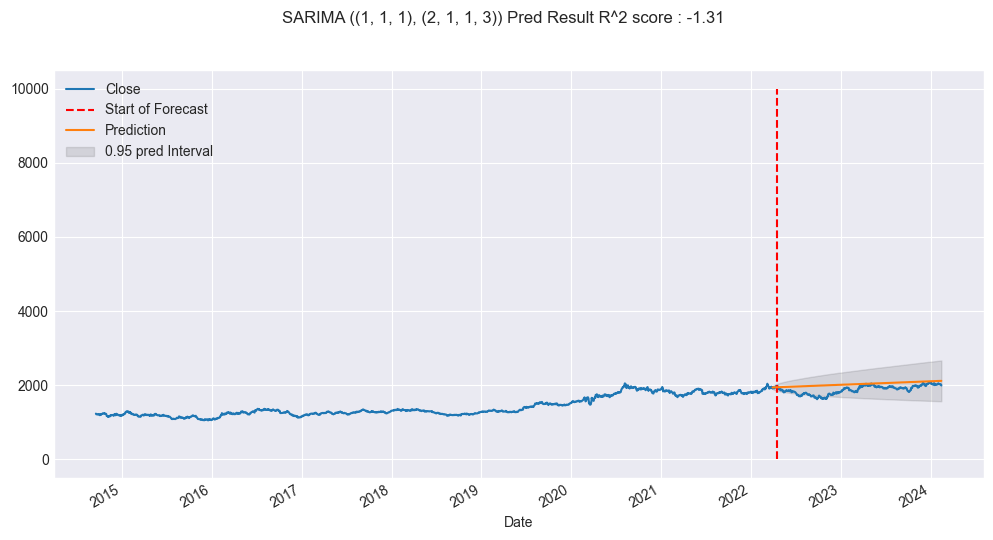

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 0, 10000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14419D+00    |proj g|=  1.14081D-01


 This problem is unconstrained.



At iterate    5    f=  4.09366D+00    |proj g|=  7.29509D-02

At iterate   10    f=  4.06646D+00    |proj g|=  8.19612D-04

At iterate   15    f=  4.06597D+00    |proj g|=  1.52711D-02

At iterate   20    f=  4.06456D+00    |proj g|=  2.42964D-03

At iterate   25    f=  4.06407D+00    |proj g|=  7.97624D-03

At iterate   30    f=  4.06371D+00    |proj g|=  2.67828D-03

At iterate   35    f=  4.06369D+00    |proj g|=  3.44983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     42      1     0     0   6.597D-06   4.064D+00
  F =   4.0636897388571693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

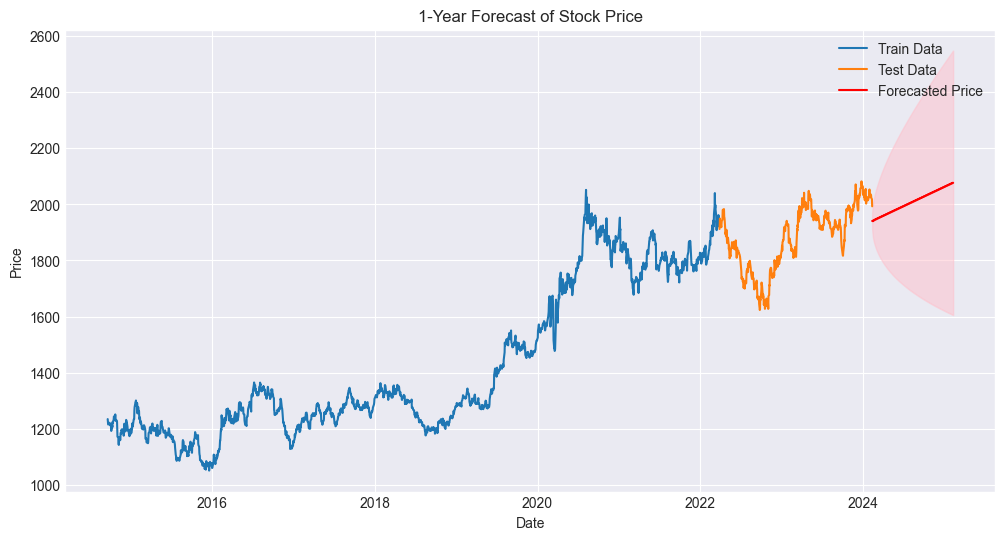

In [18]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()
model_fit.summary()

# 1년 후의 가격 예측
forecast_period = 365  # 1년에 해당하는 일수
pred = model_fit.get_forecast(steps=forecast_period)
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]

# 예측 인덱스 생성
pred_index = pd.date_range(start=test_data.index[-1], periods=forecast_period, freq='D')

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data')
plt.plot(pred_index, pred_val, color='red', label='Forecasted Price')
plt.fill_between(pred_index, pred_lb, pred_ub, color='pink', alpha=0.5)
plt.title('1-Year Forecast of Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
# Current stock price
current_price = test_data.iloc[-1]['Close']

# Stock price one year later
future_price = pred_val[-1]

# Calculate the profit rate
profit_rate = ((future_price - current_price) / current_price) * 100

print(f"Current Gold price: {current_price}")
print(f"Estimated Gold price one year later: {future_price}")
print(f"One-year profit rate: {profit_rate:.2f}%")

Current Gold price: 1992.9000244140625
Estimated Gold price one year later: 2076.6607881361115
One-year profit rate: 4.20%
